In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
from textblob import TextBlob
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,  Conv1D, Dense, Flatten, MaxPooling1D
from keras.preprocessing.text import Tokenizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from google.colab import files
uploaded = files.upload()

Saving twitterdatav1.csv to twitterdatav1.csv


In [8]:
import io
df = pd.read_csv(io.BytesIO(uploaded['twitterdatav1.csv']))

In [9]:
newtd = df.drop(['hastags','username',
       'user_followersCount', 'verifiedStatus','tweet_url','lang','replyCount','chr_count','user_friendsCount','retweetCount','likeCount','date'], axis=1)


In [10]:
newtd.head()

,tweet,topic
0,tongkat ali + mushroom blend + green blend + g...,supplements
1,@meatguyf @Ren_Chandler4 I also bought the Fre...,supplements
2,@danluu No history of doping/supplements in re...,supplements
3,@parilani Uniform code of military justice req...,supplements
4,Once again make sure you speak with your physi...,supplements


In [11]:
#clean the tweets
# Define a function to clean the tweet text
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'\b\w{1,3}\b', '',tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove punctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    # Tokenize the tweet into individual words
    words = tweet.split()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Join the cleaned words back into a string
    cleaned_tweet = ' '.join(words)
    return cleaned_tweet

newtd['ctweet'] = newtd['tweet'].apply(lambda x: clean_tweet(x))
newtd.head()

,tweet,topic,ctweet
0,tongkat ali + mushroom blend + green blend + g...,supplements,tongkat mushroom blend green blend grass feed ...
1,@meatguyf @Ren_Chandler4 I also bought the Fre...,supplements,also bought freaks geeks shoutfactory announce...
2,@danluu No history of doping/supplements in re...,supplements,history dopingsupplements recent know teams ch...
3,@parilani Uniform code of military justice req...,supplements,uniform code military justice requires bread w...
4,Once again make sure you speak with your physi...,supplements,make sure speak physician comes taking vitamin...


In [12]:
#Percentage of missing values
def perc_missing(df):
    '''prints out columns with missing values with its %'''
    for col in df.columns:
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))
    
perc_missing(newtd)

(array([3737.,    0.,    0., 2182.,    0.,    0., 3613.,    0.,    0.,
        3700.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

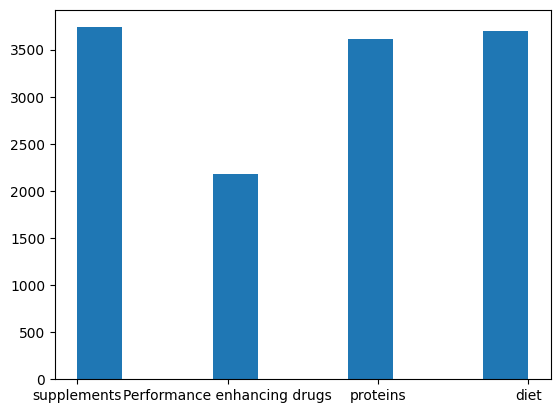

In [13]:
plt.hist(newtd['topic'])


In [14]:
# Analyze the sentiments from the given text dat i.e, our tweets
from textblob import TextBlob

def get_tweet_sentiment(tweet):
    # Create a TextBlob object from the tweet text
    blob = TextBlob(tweet)
    
    # Get the polarity score (range from -1 to 1)
    sentiment_score = blob.sentiment.polarity
    
    # Assign sentiment label based on polarity score
    if sentiment_score > 0:
        sentiment = 'positive'
    elif sentiment_score < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    return sentiment

newtd['sentiments'] = newtd["tweet"].apply(get_tweet_sentiment)

In [15]:
from textblob import TextBlob

def get_tweet_sentiment_score(tweet):
    # Create a TextBlob object from the tweet text
    blob = TextBlob(tweet)
    
    # Get the polarity score (range from -1 to 1)
    sentiment_score = blob.sentiment.polarity
    
    # Assign sentiment label based on polarity score
    if sentiment_score > 0:
        sentiment = 1
    elif sentiment_score < 0:
        sentiment = -1
    else:
        sentiment = 0
    
    return sentiment

newtd['score'] = newtd["tweet"].apply(get_tweet_sentiment_score)

In [16]:
newtd.head()

,tweet,topic,ctweet,sentiments,score
0,tongkat ali + mushroom blend + green blend + g...,supplements,tongkat mushroom blend green blend grass feed ...,negative,-1
1,@meatguyf @Ren_Chandler4 I also bought the Fre...,supplements,also bought freaks geeks shoutfactory announce...,positive,1
2,@danluu No history of doping/supplements in re...,supplements,history dopingsupplements recent know teams ch...,negative,-1
3,@parilani Uniform code of military justice req...,supplements,uniform code military justice requires bread w...,negative,-1
4,Once again make sure you speak with your physi...,supplements,make sure speak physician comes taking vitamin...,positive,1


(array([2616.,    0.,    0.,    0.,    0., 6513.,    0.,    0.,    0.,
        4103.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

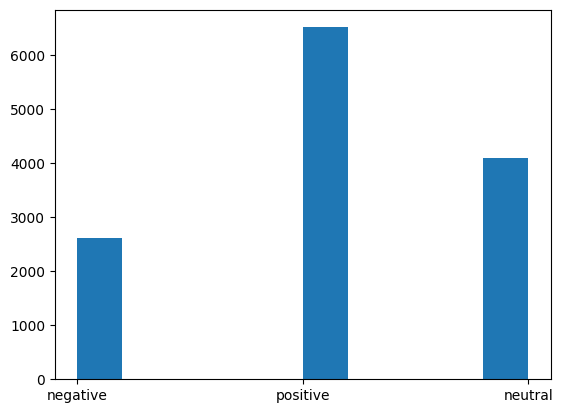

In [17]:
plt.hist(newtd['sentiments'])


In [18]:
X = newtd.drop(['sentiments','score','tweet','topic'], axis=1).values
y = newtd['score'].values
y

array([-1,  1, -1, ..., -1,  0,  0])

In [36]:
tokenizer = Tokenizer(num_words = 7000,split=" ")

tokenizer.fit_on_texts(newtd['tweet'].values)
X = tokenizer.texts_to_sequences(newtd['tweet'].values)
X = pad_sequences(X)


In [37]:
from tensorflow.keras.models import Sequential
# Define the maximum number of words and maximum length of a text sample
model = Sequential()
model.add(Embedding(7000,128,input_length=X.shape[1]))
model.add(Conv1D(64,3,activation='relu'))
model.add(MaxPooling1D(2,2))
model.add(Conv1D(32,3,activation='relu'))
model.add(MaxPooling1D(2,2))
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(4,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer= 'rmsprop',metrics= ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 93, 128)           896000    
                                                                 
 conv1d_3 (Conv1D)           (None, 91, 64)            24640     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 45, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 43, 32)            6176      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 21, 32)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 672)              

In [38]:
y = pd.get_dummies(newtd['topic']).values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20)

In [40]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.1,
          epochs=10, batch_size=100)

Epoch 1/10
96/96 [==============================] - 9s 79ms/step - loss: 0.0399 - accuracy: 0.9677 - val_loss: 0.2524 - val_accuracy: 0.8697
Epoch 2/10
96/96 [==============================] - 8s 85ms/step - loss: 0.0344 - accuracy: 0.9727 - val_loss: 0.2606 - val_accuracy: 0.8659
Epoch 3/10
96/96 [==============================] - 7s 73ms/step - loss: 0.0327 - accuracy: 0.9732 - val_loss: 0.2735 - val_accuracy: 0.8621
Epoch 4/10
96/96 [==============================] - 8s 85ms/step - loss: 0.0293 - accuracy: 0.9765 - val_loss: 0.2871 - val_accuracy: 0.8602
Epoch 5/10
96/96 [==============================] - 7s 78ms/step - loss: 0.0292 - accuracy: 0.9771 - val_loss: 0.3016 - val_accuracy: 0.8612
Epoch 6/10
96/96 [==============================] - 8s 83ms/step - loss: 0.0264 - accuracy: 0.9789 - val_loss: 0.3152 - val_accuracy: 0.8527
Epoch 7/10
96/96 [==============================] - 8s 84ms/step - loss: 0.0275 - accuracy: 0.9785 - val_loss: 0.3117 - val_accuracy: 0.8565
Epoch 8/10
96

In [51]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.01) # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", accuracy)
# Generate a confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Confusion matrix:")
print(cm)

83/83 [==============================] - 1s 14ms/step
Test accuracy: 0.752550056667926
Confusion matrix:
[[382  41   3   9]
 [ 78 610  36  21]
 [ 26 143 536  16]
 [ 23  85  30 608]]


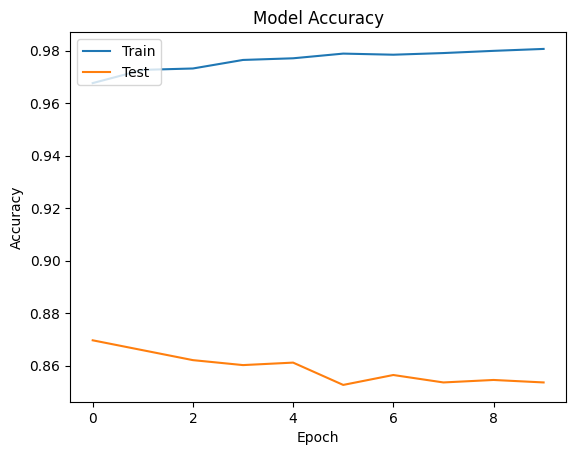

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [43]:
# Generate a confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Confusion matrix:")
print(cm)

Confusion matrix:
[[382  41   3   9]
 [ 78 610  36  21]
 [ 26 143 536  16]
 [ 23  85  30 608]]
